In [143]:
import example_utils as utils
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

n_total = 10000
end_time = 200

parameters = {
    'novid70': {
        'graph_name': 'NOVID 70%',
        'color': 'tab:purple',
        'linestyle': '-',
        'app_adoption': 70,
        'params': {
            'novid_soft_multiplier_1': 0.125,
            'novid_soft_multiplier_2': 0.125,
            'novid_soft_multiplier_3': 0.25,
            'novid_soft_multiplier_4': 0.5,
        },
    },
    'ct70': {
        'graph_name': 'Contact Tracing 70%',
        'color': 'tab:orange',
        'linestyle': '-',
        'app_adoption': 70,
        'params': {
            'novid_soft_multiplier_1': 0.125,
            'novid_soft_multiplier_2': 0.125,
            'novid_soft_multiplier_3': 1.0,
            'novid_soft_multiplier_4': 1.0,
        },
    },
    'no app': {
        'graph_name': 'No App',
        'color': 'tab:red',
        'linestyle': '-',
        'app_adoption': 70,
        'params': {
            'novid_soft_multiplier_1': 1.0,
            'novid_soft_multiplier_2': 1.0,
            'novid_soft_multiplier_3': 1.0,
            'novid_soft_multiplier_4': 1.0,
        },
    },
    'ct_strict70': {
        'graph_name': 'Strict Contact Tracing 70%',
        'color': 'tab:brown',
        'linestyle': '-',
        'app_adoption': 70,
        'params': {
            'novid_soft_multiplier_1': 0.0,
            'novid_soft_multiplier_2': 0.0,
            'novid_soft_multiplier_3': 1.0,
            'novid_soft_multiplier_4': 1.0,
        },
    },
    'novid35': {
        'graph_name': 'NOVID 35%',
        'color': 'tab:blue',
        'linestyle': '--',
        'app_adoption': 35,
        'params': {
            'novid_soft_multiplier_1': 0.125,
            'novid_soft_multiplier_2': 0.125,
            'novid_soft_multiplier_3': 0.25,
            'novid_soft_multiplier_4': 0.5,
        },
    },
    'ct35': {
        'graph_name': 'Contact Tracing 35%',
        'color': 'tab:orange',
        'linestyle': '--',
        'app_adoption': 35,
        'params': {
            'novid_soft_multiplier_1': 0.125,
            'novid_soft_multiplier_2': 0.125,
            'novid_soft_multiplier_3': 1.0,
            'novid_soft_multiplier_4': 1.0,
        },
    },
}

app_users_param = [
    "app_users_fraction_0_9",
    "app_users_fraction_10_19", 
    "app_users_fraction_20_29",
    "app_users_fraction_30_39",
    "app_users_fraction_40_49",
    "app_users_fraction_50_59",
    "app_users_fraction_60_69",
    "app_users_fraction_70_79",
    "app_users_fraction_80"
]
base_app_adoption = 72.2728

if 'results' not in globals():
    results = {}


In [144]:
def run_sim(name, force=False):
    if not force and name in results:
        print(f'Already ran simulation {name}, skipping')
        return
    
    params = utils.get_baseline_parameters()
    params.set_param( 'n_total', n_total )

    params.set_param( 'test_on_symptoms', 1 )
    params.set_param( 'testing_symptoms_time_on', 1 )
    params.set_param( 'trace_on_positive', 1 )
    params.set_param( 'app_turn_on_time', 1 )
    params.set_param( 'intervention_start_time', 1 )
    params.set_param( 'tracing_network_depth', 1 )
    params.set_param( 'quarantine_on_traced', 1 )

    params.set_param( 'self_quarantine_fraction', 0 )
    params.set_param( 'quarantine_household_on_positive', 0 )

    params.set_param( 'quarantine_dropout_self', 0 )
    params.set_param( 'quarantine_dropout_traced_symptoms', 0 )
    params.set_param( 'quarantine_dropout_traced_positive', 0 )
    params.set_param( 'quarantine_dropout_positive', 0 )
    params.set_param( 'quarantine_compliance_traced_symptoms', 1 ) # TODO: check effect
    params.set_param( 'quarantine_compliance_traced_positive', 1 ) # same
    
    params.set_param( 'soft_quarantine_on', 1 )
    params.set_param( 'novid_on', 1 )
    params.set_param( 'novid_quarantine_length', 7 )
    params.set_param( 'traceable_interaction_fraction', 1 )
    
    app_users_multiplier = parameters[name]['app_adoption']/base_app_adoption
    for p in app_users_param:
        params.set_param(p, params.get_param(p) * app_users_multiplier)

    for key, value in parameters[name]['params'].items():
        params.set_param(key, value)
    
    print(f'Starting simulation {name}')
    sim = utils.get_simulation(params)
    sim.steps(end_time)
    results[name] = sim.results
    print(f'Finished simulation {name}')

def run_all(force=False):
    for name in parameters:
        run_sim(name, force=force)

def graph(statistic, names):
    graph_results = {}
    graph_names = []
    colors = []
    linestyles = []
    
    for name in names:
        gn = parameters[name]['graph_name']
        if name not in results:
            run_sim(name)
        graph_results[gn] = results[name][statistic]
        graph_names.append(gn)
        colors.append(parameters[name]['color'])
        linestyles.append(parameters[name]['linestyle'])
    graph_results['Time'] = results[names[0]]['time']
    
    fig, ax = plt.subplots(facecolor='w')
    df = pd.DataFrame(graph_results)
    df.plot(
        x = 'Time',
        y = graph_names,
        title=statistic,
        color=colors,
        style=linestyles,
        ax=ax
    )
    plt.legend(loc='upper left', bbox_to_anchor=(1.01,1.026))
    
    if statistic.startswith('R_inst'):
        plt.axhline(y=1.0, color='black')
    if statistic == 'total_infected':
        plt.axhline(y=0.1*n_total, color='black')

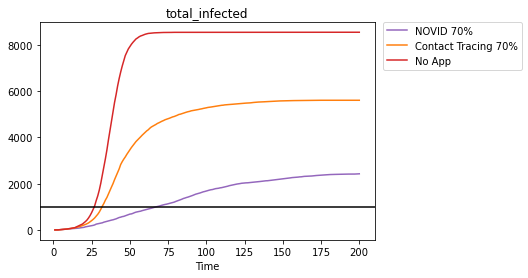

In [145]:
graph('total_infected', ['novid70', 'ct70', 'no app'])

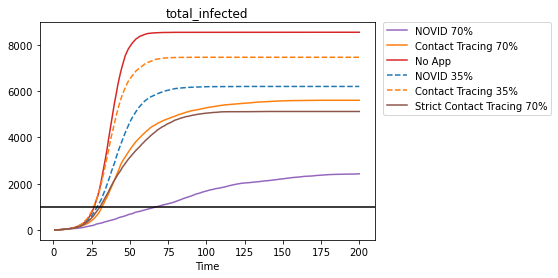

In [146]:
graph('total_infected', ['novid70', 'ct70', 'no app', 'novid35', 'ct35', 'ct_strict70'])

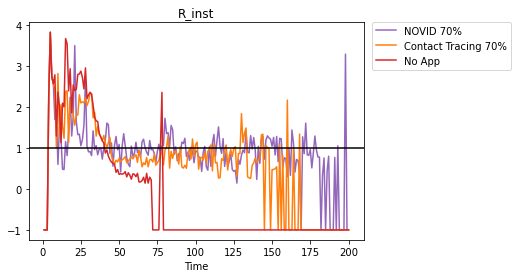

In [147]:
graph('R_inst', ['novid70', 'ct70', 'no app'])

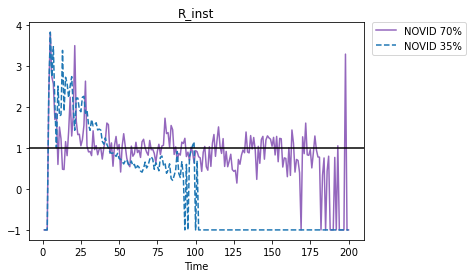

In [148]:
graph('R_inst', ['novid70', 'novid35'])

In [63]:
#run_all(force=True)

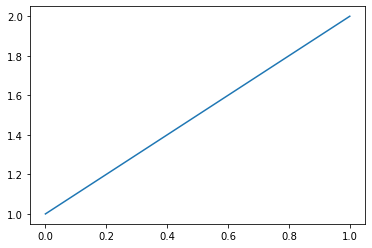

In [8]:
plt.plot([1,2])

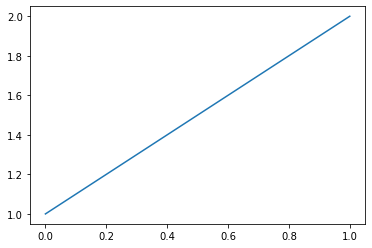

In [9]:
fig, ax = plt.subplots(facecolor='w')
ax.plot([1,2])